# Wine Quality

**Objectives:**
* Build a model to predict wine quality 
* Model will be tuned based on [wine's traits](http://winefolly.com/review/wine-characteristics/)

**Summary:**
* Classes are umbalanced, much more bad wines than good wines
* SVM (classification) seems to do a better job at predicting wine quality

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.feature_extraction import DictVectorizer
from sklearn.externals import joblib
import sklearn.svm
import sklearn.linear_model
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
dataset_url = 'http://mlr.cs.umass.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(dataset_url)

## Checking the data

In [3]:
data.head(3)

,"fixed acidity;""volatile acidity"";""citric acid"";""residual sugar"";""chlorides"";""free sulfur dioxide"";""total sulfur dioxide"";""density"";""pH"";""sulphates"";""alcohol"";""quality"""
0,7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
1,7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5
2,7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;...


Actual CSV data. Cleaning

In [4]:
data = pd.read_csv(dataset_url, sep = ';')
data.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


OK

In [5]:
data.shape

(1599, 12)

159 samples, 12 parameters

### Summary stats of the data

In [6]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


* data is numeric
* it will be necessary to standardize the data

## Split data into Train and Test set

In [7]:
y = data.quality
X = data.drop('quality', axis=1)

I will stratify it by the target, so I ensure that training set looks similar to test set.
 
This is good to do in case the data is not normally distributed. 

I am ensuring that the training ans test set does not look different from the overall sample

So stratifying is a way to ensure my sample is a representative sample.

In [8]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2, random_state = 123, stratify = y)

## Feature Scaling / Model preprocessing

Implicitly weights all features equally in their representation. It's necessary to do when  model is sensitive to magnitude.

This is done by:

* Fit the transformer on the training set (saving the means and standard deviations)
* Apply the transformer to the training set (scaling the training data)
* Apply the transformer to the test set (using the same means and standard deviations)

In [9]:
#scaler = preprocessing.StandardScaler().fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_test_scaled = scaler.transform(X_test)

All the preprocessing steps can the taken care of by the model pipeline. so:

In [10]:
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestRegressor(n_estimators=100))

In [11]:
# transforms the data using StandardScaler() and fits a model using a random forest regressor

## Prepare Cross-Validation pipeline

In [12]:
pipeline.get_params()

{'randomforestregressor': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
 'randomforestregressor__bootstrap': True,
 'randomforestregressor__criterion': 'mse',
 'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 'auto',
 'randomforestregressor__max_leaf_nodes': None,
 'randomforestregressor__min_impurity_split': 1e-07,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__min_weight_fraction_leaf': 0.0,
 'randomforestregressor__n_estimators': 100,
 'randomforestregressor__n_jobs': 1,
 'randomforestregressor__oob_score': False,
 'randomforestregressor__random_state': None,
 'rando

[info](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [13]:
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}

## Perform CV

In [14]:
clf = GridSearchCV(pipeline, hyperparameters, cv = 10)

In [15]:
# Fit and tune model
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('randomforestregressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'randomforestregressor__max_depth': [None, 5, 3, 1], 'randomforestregressor__max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [16]:
# best param for random tree:
clf.best_params_

{'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 'sqrt'}

## Refit on the training set

GridSearchCV will automatically refit the model with the best set of hyperparameters using the entire training set.

In [17]:
clf.refit

True

## Evaluate model

In [18]:
y_pred = clf.predict(X_test)

In [19]:
r2_score(y_test, y_pred)

0.46187105757007096

In [20]:
mean_squared_error(y_test, y_pred)

0.34724031249999998

In [21]:
x = zip(y_test, y_pred)
#x

Low mean square error.

In [22]:
# Save model as pkl file:
joblib.dump(clf, 'rf_regressor.pkl')

['rf_regressor.pkl']

## Changing model
I will use Random Forest Classifier

In [23]:
#means = clf.cv_results_['mean_test_score']
#stds = clf.cv_results_['std_test_score']

#for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#        print("%0.3f (+/-%0.03f) for %r"
#              % (mean, std * 2, params))

I will try to imporve the model results

### I will set 1 to "good quality" and 0 if not good

if Quality >= 7 it will be set to Good

In [24]:
y = data.quality.values

In [25]:
y = np.asarray([1 if i >= 7 else 0 for i in y])

In [26]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
X = data.drop('quality', axis=1)
X = X.as_matrix()

### Tune parameters:
**Number of trees** is very important

Train Random Forest with different number of predicors
Get an estimate of the **prediction accuracy**

In [28]:
# cross_val_score:
# I give it a classifier and the whole (training + validation) dataset 
# and it automatically performs 10 rounds of cross-validation (cv)
# by splitting the data into random training/validation sets, 
# fitting the training set, and computing the score on the validation set

n_estimators = number of trees

In [29]:
scores = []
for val in range(1, 41):
    clf = RandomForestClassifier(n_estimators= val)
    validated = cross_val_score(clf, X, y, cv = 10)
    scores.append(validated)

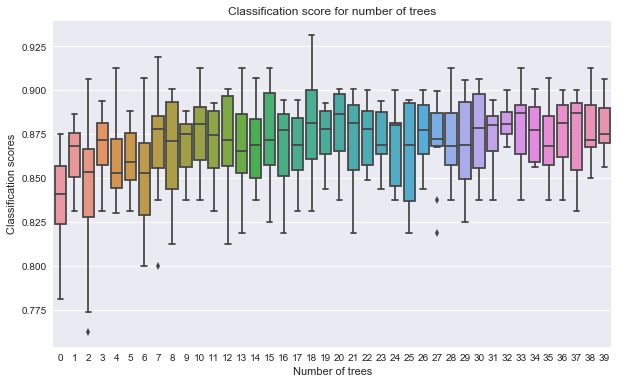

In [30]:
sns.boxplot(data=scores)
plt.xlabel('Number of trees')
plt.ylabel('Classification scores')
plt.title('Classification score for number of trees')

#### Evaluate the classes

In [31]:
good_ratio = float(sum(y)) / len(y)
bad_ratio = 1 - good_ratio
print 'Ratio of good wine: ', good_ratio
print'Ratio of bad wine: ', bad_ratio

Ratio of good wine:  0.135709818637
Ratio of bad wine:  0.864290181363


I have much more 'bad wines' than 'good ones'. So the classes are unbalanced.

The accuracy for the classification will be misleading, so I will use the F1 accuracy instead, that is less sensitive to imbalance.

In statistical analysis of binary classification, the F1 score (also
F-score or F-measure) is a measure of a test’s accuracy. It considers
both the precision p and the recall r of the test to compute
the score.

[source](https://adamyedidia.files.wordpress.com/2014/11/f_score.pdf)

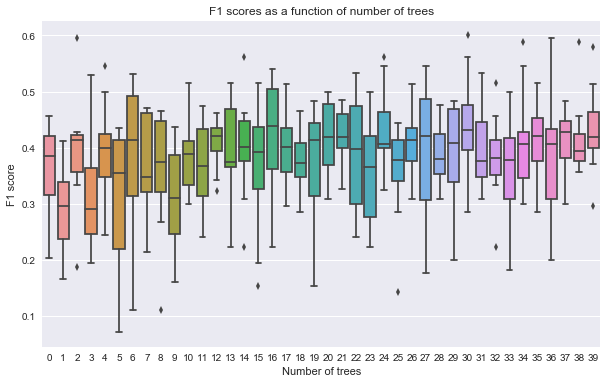

In [32]:
scores = []
for val in range(1, 41):
    clf = RandomForestClassifier(n_estimators= val)
    validated = cross_val_score(clf, X, y, cv = 10, scoring = "f1")
    scores.append(validated)

sns.boxplot(data=scores)
plt.xlabel('Number of trees')
plt.ylabel('F1 score')
plt.title('F1 scores as a function of number of trees')

Scores are clusteres around 40%. 

Decision tree = 16

In [33]:
clf = RandomForestClassifier(n_estimators = 16)
f1_score = cross_val_score(clf, X, y, cv=10, scoring='f1')
f1_score.mean()

0.43860376890667246

### Probability calibration

When performing classification you often want not only to predict the class label, but also obtain a probability of the respective label. This probability gives you some kind of confidence on the prediction

[source](http://scikit-learn.org/stable/modules/model_evaluation.html)

In [34]:
clf = RandomForestClassifier(n_estimators = 16)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=16, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [35]:
clf.predict(X)[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [36]:
clf.predict_proba(X)[:10]

array([[ 1.    ,  0.    ],
       [ 1.    ,  0.    ],
       [ 1.    ,  0.    ],
       [ 1.    ,  0.    ],
       [ 1.    ,  0.    ],
       [ 1.    ,  0.    ],
       [ 1.    ,  0.    ],
       [ 0.5625,  0.4375],
       [ 0.125 ,  0.875 ],
       [ 1.    ,  0.    ]])

The values above mean that for the 1st value predicted (y = 0, given by clf.predict(X)), there's 1 probability for it being class 0 and 0 probability for it being class 1.

In [37]:
clf.predict_proba(X)[8]

array([ 0.125,  0.875])

The values above mean that for the value before last predicted (y = 1, given by clf.predict(X)), there's 0.1875 probability (or 18.755%) for it being class 0 and 0.8125 probability (or 81.25%) for it being class 1.

I will build a prediction based on the predicted probabilities.

If the predicted probability is > 0.5, label wine as class 1

In [38]:
prediction = clf.predict(X)
prediction_from_proba = (clf.predict_proba(X)[:,1]>0.5).astype(int)

In [39]:
prediction[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [40]:
prediction_from_proba[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [41]:
correct = [1 if prediction_from_proba[i]== prediction[i] else 0 for i in range(len(prediction))]
(sum(correct)/len(correct))

1

### Is 0.5 the best cut-off?

In [42]:
import sklearn
def cutoff_predict(clf, X, cutoff):
    """
    Function to compute the best cut-off from the prediction probability class membership.
    
    Inputs:
    clf: trained classier object
    X: 2D array of features
    cutoff: cutoff value
    
    Returns: 
    Array
    """
    
    return (clf.predict_proba(X)[:, 1]> cutoff).astype(int)

def custom_f1(cutoff):
    """
    Function to evaluate different cutoff values using cross_validation
    """
    
    def f1_cutoff(clf, X, y):
        ypred = cutoff_predict(clf, X, cutoff)
        return sklearn.metrics.f1_score(y, ypred)

    return f1_cutoff

In [43]:
scores = []

for cutoff in np.arange(0.1, 0.9, 0.1):
    clf = RandomForestClassifier(n_estimators = 16)
    score_list = cross_val_score(clf, X, y, cv = 10, scoring=custom_f1(cutoff))   
    scores.append(score_list)

/Users/MarianaSouza/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


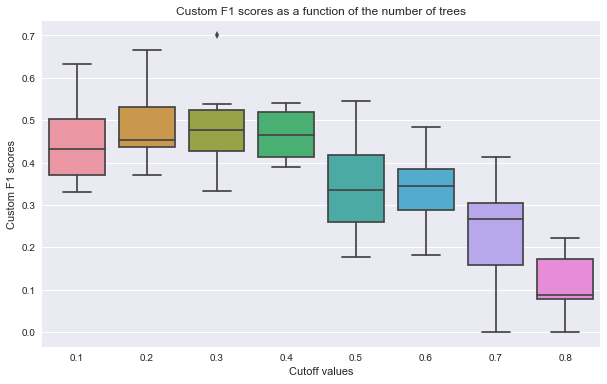

In [44]:
sns.boxplot(x=np.arange(0.1,0.9,0.1), y=scores)
plt.xlabel('Cutoff values')
plt.ylabel('Custom F1 scores')
plt.title('Custom F1 scores as a function of the number of trees')
plt.show()

Cut-off up to 0.4 seems to give best predictive performance

## Feature selection
It is the process of selecting those features in the data that contribute most to the prediction variable or output in which I am interested

In [45]:
clf = RandomForestClassifier(n_estimators= 16)
clf.fit(X, y)

imp = clf.feature_importances_
names = data.columns

imp, names = zip(*sorted(zip(imp, names)))

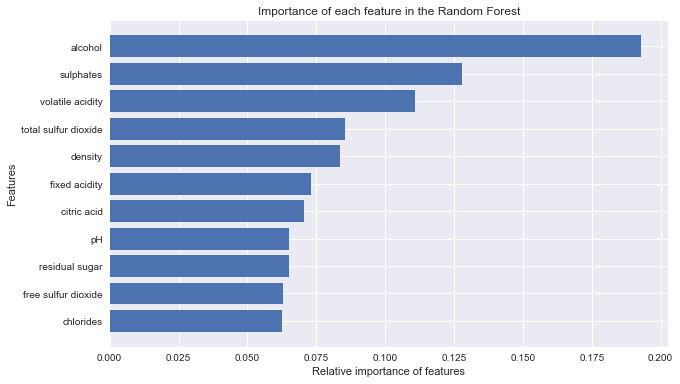

In [46]:
plt.barh(range(len(names)), imp, align = 'center')
plt.yticks(range(len(names)), names)

plt.xlabel('Relative importance of features')
plt.ylabel('Features')
plt.title('Importance of each feature in the Random Forest')

## Building the models
I will use the **2 most important features, alcohol and sulphates**

In [47]:
important_list = clf.feature_importances_

In [48]:
i1_important = list(important_list).index(max(important_list))
# sorted[-2]will sort the list and get the second biggest
i2_important = list(important_list).index(sorted(clf.feature_importances_)[-2])

In [49]:
X_imp = X[:,[i1_important, i2_important]]

In [50]:
X_imp

array([[  9.4 ,   0.56],
       [  9.8 ,   0.68],
       [  9.8 ,   0.65],
       ..., 
       [ 11.  ,   0.75],
       [ 10.2 ,   0.71],
       [ 11.  ,   0.66]])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size = 0.25, random_state = 0)

In [52]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Fit Classifiers

In [53]:
classifier1 = RandomForestClassifier(n_estimators = 16, criterion = 'entropy')
classifier1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=16, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [54]:
classifier2 = DecisionTreeClassifier()
classifier2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [55]:
classifier3 = sklearn.svm.SVC(C=1.0, gamma=1.0)
classifier3.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Prediction

In [56]:
y_pred1 = classifier1.predict(X_test)
cm = confusion_matrix(y_test, y_pred1)
cm

array([[322,  33],
       [ 24,  21]])

In [57]:
y_pred2 = classifier2.predict(X_test)
cm = confusion_matrix(y_test, y_pred2)
cm

array([[311,  44],
       [ 25,  20]])

In [58]:
y_pred3 = classifier3.predict(X_test)
cm = confusion_matrix(y_test, y_pred3)
cm

array([[350,   5],
       [ 36,   9]])

In [59]:
### SVM has less wrong results

## Visualization

### Visualising the Training set results

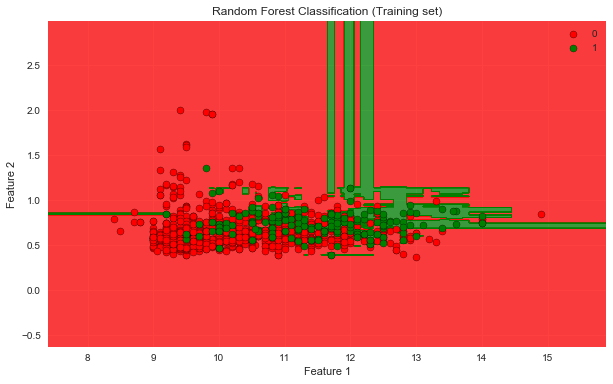

In [60]:
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier1.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j, edgecolor = 'black')
plt.title('Random Forest Classification (Training set)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

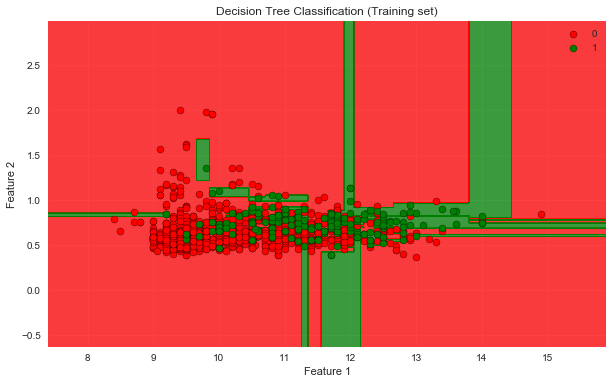

In [61]:
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier2.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j, edgecolor = 'black')
plt.title('Decision Tree Classification (Training set)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

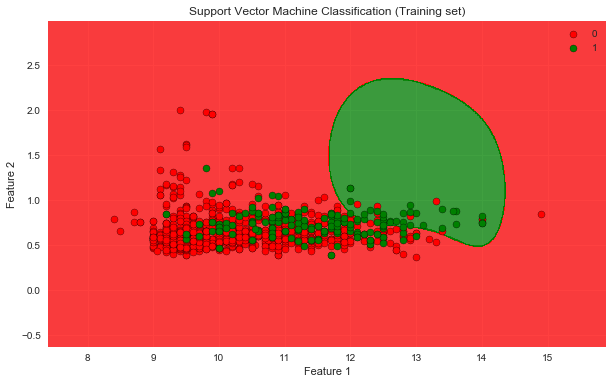

In [62]:
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier3.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j, edgecolor = 'black')
plt.title('Support Vector Machine Classification (Training set)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

SVM has fewer false positives and overal precision.

As I mentioned before, the classes are unbalanced and it seems that this will influence the model results.

### Visualising the Training set results

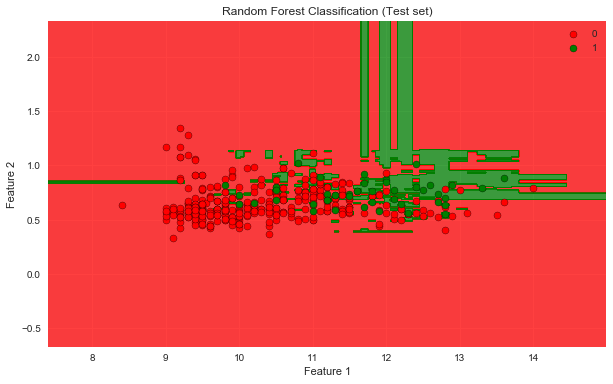

In [68]:
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier1.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j, edgecolor = 'black')
plt.title('Random Forest Classification (Test set)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

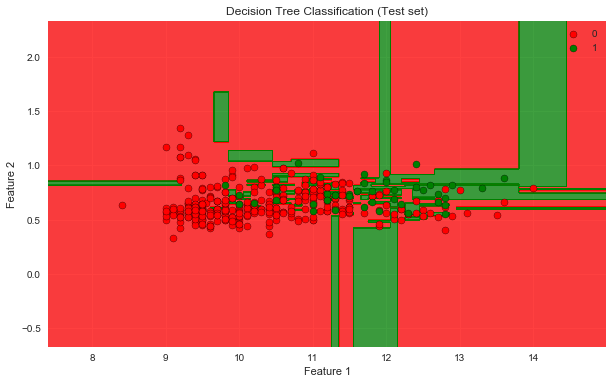

In [67]:
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier2.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j, edgecolor = 'black')
plt.title('Decision Tree Classification (Test set)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

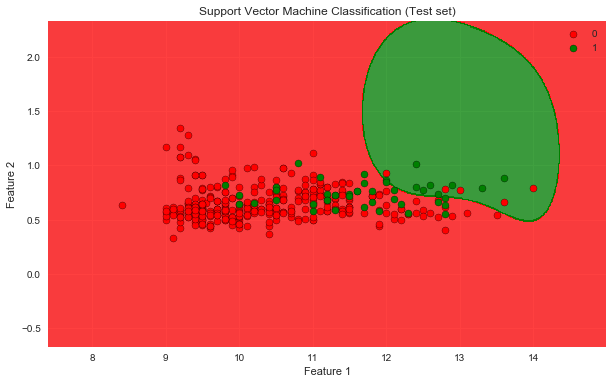

In [66]:
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier3.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j, edgecolor = 'black')
plt.title('Support Vector Machine Classification (Test set)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()